In [4]:
import numpy as np
import pandas as pd
import os
import pickle
import cv2
import csv
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
#df = pd.DataFrame(columns=['img', 'steering', 'acc', 'break', 'src_cam', 'filter'])
#df.loc[1]

In [6]:
data_dir = 'data3/'
data_log = 'driving_log.csv'

if False:
    # read in csv
    # centerImg, leftImg, rightImg, steering angle, throttle, break, speed
    csv_filename = '%s%s' % (data_dir, data_log)
    print(csv_filename)
    y_files = []
    #y_data = np.array((None,4));
    y_data = np.array([]).reshape(0,4)
    with open(csv_filename, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            y_files.append((row[0].strip(), row[1].strip(), row[2].strip()));
            y_data = np.vstack([y_data, (float(row[3]), float(row[4]), float(row[5]), float(row[6]))]);

In [7]:
if False:
    # center,left,right,steering,throttle,brake,speed
    import matplotlib.pyplot as plt
    #plt.plot(y_data[:,3])
    plt.plot(y_data[:,0])
    plt.ylabel('some numbers')
    plt.show()

<pre>
  Image: data/IMG/center_2016_12_01_13_34_32_267.jpg
  Format: JPEG (Joint Photographic Experts Group JFIF format)
  Mime type: image/jpeg
  Class: DirectClass
  Geometry: 320x160+0+0
  Units: Undefined
  Type: TrueColor
  Endianess: Undefined
  Colorspace: sRGB
  Depth: 8-bit
  Channel depth:
    red: 8-bit
    green: 8-bit
    blue: 8-bit
  Channel statistics:
    Pixels: 51200
    Red:
      min: 0 (0)
      max: 255 (1)
      mean: 125.626 (0.492651)
      standard deviation: 50.7508 (0.199023)
      kurtosis: 0.512638
      skewness: 0.488123
    Green:
      min: 0 (0)
      max: 255 (1)
      mean: 125.031 (0.490318)
      standard deviation: 47.3026 (0.1855)
      kurtosis: 0.0985292
      skewness: 0.246887
    Blue:
      min: 0 (0)
      max: 255 (1)
      mean: 107.621 (0.422041)
      standard deviation: 57.1212 (0.224005)
      kurtosis: -0.453599
      skewness: 0.367842
  Image statistics:
    Overall:
      min: 0 (0)
      max: 255 (1)
      mean: 119.426 (0.468337)
      standard deviation: 51.8845 (0.203469)
      kurtosis: 0.156384
      skewness: 0.303661
  Rendering intent: Perceptual
  Gamma: 0.454545
  Chromaticity:
    red primary: (0.64,0.33)
    green primary: (0.3,0.6)
    blue primary: (0.15,0.06)
    white point: (0.3127,0.329)
  Background color: white
  Border color: srgb(223,223,223)
  Matte color: grey74
  Transparent color: black
  Interlace: None
  Intensity: Undefined
  Compose: Over
  Page geometry: 320x160+0+0
  Dispose: Undefined
  Iterations: 0
  Compression: JPEG
  Quality: 75
  Orientation: Undefined
  Properties:
    date:create: 2017-01-19T19:54:29+00:00
    date:modify: 2016-12-01T21:34:32+00:00
    jpeg:colorspace: 2
    jpeg:sampling-factor: 2x2,1x1,1x1
    signature: d366febf445779d904002b67f8b4599d76b07851f2a185d7f09543873a01a275
  Artifacts:
    filename: data/IMG/center_2016_12_01_13_34_32_267.jpg
    verbose: true
  Tainted: False
  Filesize: 13.5KB
  Number pixels: 51.2K
  Pixels per second: 0B
  User time: 0.000u
  Elapsed time: 0:01.000
  Version: ImageMagick 6.8.9-9 Q16 x86_64 2016-11-29 http://www.imagemagick.org
</pre>

In [8]:
import os
os.listdir("/mnt/data/")

['dataset1_udacity', 'dataset2_twe_one_lap', 'dataset3_ssz_one_lap']

In [9]:
csv = pd.read_csv('/mnt/data/dataset2_twe_one_lap/driving_log.csv')
#csv = pd.read_csv('/mnt/data/dataset1_udacity/driving_log.csv')

for i in csv.columns:
    if isinstance(csv[i][1], str):
        csv[i] = csv[i].map(str.strip)


In [10]:
#isis(csv['left'][0])
isinstance(csv['left'][0], str)
#np.isnan(csv['left'][0]) 
#csv

False

In [11]:
# TODO: BATCH SO I DONT RUN INTO MEMORY ISSUES

# orginal size: 320x160 RGB 8-bit
IMG_W = 32*4; # = 128
IMG_H = 16*4; # = 64
#steering_offset = 0.25;
steering_offset = 0.1;

num_of_samples = len(csv) * 3 * 2; # length * 3 camera angles * 2 flipped

X_test = None; X_train = None;
y_test = None; y_train = None;
features = None; label = None;
features = np.zeros(shape=[num_of_samples,IMG_H,IMG_W,3]);
labels   = np.zeros(shape=[num_of_samples])

img_counter = 0;

for i in range(len(csv)):
#    left_img   = './data2/' + csv['left'][i];
#    right_img  = './data2/' + csv['right'][i];
#    center_img  = './data2/' + csv['center'][i];
    left_img   = './data3/IMG/' + os.path.basename(csv['left'][i]);
    right_img  = './data3/IMG/' + os.path.basename(csv['right'][i]);
    center_img = './data3/IMG/' + os.path.basename(csv['center'][i]);   
    steering_angle = csv['steering'][i];
    
    for camera, img_path in (('L', left_img), ('R', right_img), ('C', center_img)):    
#    for camera, img_path in [('C', center_img)]:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV does not use RGB, it uses BGR
        img = cv2.resize(img, (IMG_W, IMG_H))
        flipped = cv2.flip(img,1)
        
        if camera == 'L': steering_angle = steering_angle + steering_offset;  # TESTEN
        if camera == 'R': steering_angle = steering_angle - steering_offset;  # TESTEN           
#       EVTL: np.clip, np.min
        
        features[img_counter,:,:,:] = img;
        labels[img_counter] = steering_angle;
        img_counter += 1;
        
        features[img_counter,:,:,:] = flipped;
        labels[img_counter] = -steering_angle;
        img_counter += 1;        

#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0)
features = None;
#labels = None;

In [12]:
print(labels)
print(np.sum(labels))
print(np.sum(y_train))
print(np.sum(y_test))
#1/0

[ 0.1 -0.1  0.  ..., -0.   0.  -0. ]
0.0
-3.5527136788e-15
0.0


In [13]:
batch_size = 1000;

batches_train = len(X_train) // batch_size
for i in range(batches_train):
    train = {'features': X_train[i*batch_size:(i+1)*batch_size], 'labels': y_train[i*batch_size:(i+1)*batch_size]}
    print('- Saving train_%d.p' % (i+1))
    with open("/mnt/data3/train_%d.p" % (i+1), "wb") as f:
        pickle.dump(train, f)
print('DONE')

- Saving train_1.p
- Saving train_2.p
- Saving train_3.p
- Saving train_4.p
- Saving train_5.p
- Saving train_6.p
- Saving train_7.p
- Saving train_8.p
- Saving train_9.p
DONE


In [14]:
batches_test = len(X_test) // batch_size;
print(batches_test)
for i in range(batches_test):
    test  = {'features': X_test[i*batch_size:(i+1)*batch_size], 'labels': y_test[i*batch_size:(i+1)*batch_size]}
    print('- Saving test_%d.p' % (i+1))    
    with open("/mnt/data3/test_%d.p" % (i+1), "wb") as f:
        pickle.dump(test, f)

print('DONE')

0
DONE


In [46]:
x = np.array([1,2,3,4,5,6,7,8])
print(x[0:5])
print(x[5:8])

[1 2 3 4 5]
[6 7 8]


# Generate data for pre-training

In [48]:
# orginal size: 320x160 RGB 8-bit

img_counter = 0;

idx_max = csv['steering'] > np.max(csv['steering']) - 0.45
idx_min = csv['steering'] < np.min(csv['steering']) + 0.30
idx = idx_max | idx_min
idx[0:10] = True; # straight road
idx = np.where(idx == True)[0]

num_of_samples = len(idx);
print('Number of samples %d' % num_of_samples)

features      = np.zeros(shape=[num_of_samples,IMG_H,IMG_W,3]);
labels        = np.zeros(shape=[num_of_samples,3])
features_more = np.zeros(shape=[num_of_samples,])

for _, i in np.ndenumerate(idx):
#    left_img   = './data2/' + csv['left'][i];
#    right_img  = './data2/' + csv['right'][i];
#    center_img = './data2/' + csv['center'][i];   
    center_img = './data2/IMG/' + os.path.basename(csv['center'][i]);     
    steering_angle = csv['steering'][i];   
    
    throttle = csv['throttle'][i];   
    brake    = csv['brake'][i];           
    speed    = csv['speed'][i];               
    
    #camera = 'C'
    img = cv2.imread(center_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV does not use RGB, it uses BGR
    img = cv2.resize(img, (IMG_W, IMG_H))
    flipped = cv2.flip(img,1)

    #if camera == 'L': steering_angle = steering_angle + steering_offset;  # TESTEN
    #if camera == 'R': steering_angle = steering_angle - steering_offset;  # TESTEN           

    features[img_counter,:,:,:] = img;
    labels[img_counter,0] = steering_angle;
    labels[img_counter,1] = throttle;
    labels[img_counter,2] = brake;    
    features_more[img_counter] = speed;
    img_counter += 1;

    #features[img_counter,:,:,:] = flipped;
    #labels[img_counter] = -steering_angle;
    #img_counter += 1;        

X_pretrain = features;
y_pretrain = labels;
z_pretrain = features_more;

Number of samples 53


In [49]:
pretrain = {'features': X_pretrain, 'labels': y_pretrain, 'features_more': z_pretrain}
with open("/mnt/data2/train_pretrain.p", "wb") as f:
    pickle.dump(pretrain, f)

In [50]:
#from klepto.archives import dir_archive
#train_archive = dir_archive("./data2/train.p", {}, cached=True, serialized=True)
#train_archive['features'] = X_train;
#train_archive.dump()
#train_archive['labels'] = y_train;
#train_archive.dump()
#train_archive.clear()
#test_archive  = dir_archive("./data2/test.p", test, serialized=True)

In [51]:
whos

Variable           Type              Data/Info
----------------------------------------------
IMG_H              int               64
IMG_W              int               128
X_pretrain         ndarray           53x64x128x3: 1302528 elems, type `float64`, 10420224 bytes (9.9375 Mb)
X_test             ndarray           0x64x128x3: 0 elems, type `float64`, 0 bytes
X_train            ndarray           8082x64x128x3: 198623232 elems, type `float64`, 1588985856 bytes (1515.375 Mb)
batch_size         int               1000
batches_test       int               0
batches_train      int               8
brake              int64             0
camera             str               C
center_img         str               ./data2/IMG/center_2017_01_28_12_45_37_458.jpg
csv                DataFrame                                  <...>\n[1347 rows x 7 columns]
cv2                module            <module 'cv2' from '/home<...>35m-x86_64-linux-gnu.so'>
data_dir           str               data2/
data_lo

# DataGenerator Class

In [418]:
import self_driving_car
from imp import reload
preprocessor = self_driving_car.data_generator.DataPreprocessor()
preprocessor.preprocess(basepath = "/mnt/data/", dataset = "dataset1_udacity")
#preprocessor.preprocess(basepath = "/mnt/data/", dataset = "dataset2_twe_one_lap")
#preprocessor.preprocess(basepath = "/mnt/data/", dataset = "dataset3_ssz_one_lap")
df = preprocessor.save_index()
df

,img,steering,throttle,brake,speed,cam,filter
0,dataset3_ssz_one_lap/IMG_preprocessed/mod_iden...,0.0,0.0,0.0,0.000078,C,mod_identity
1,dataset3_ssz_one_lap/IMG_preprocessed/mod_ligh...,0.0,0.0,0.0,0.000078,C,mod_lighting
2,dataset3_ssz_one_lap/IMG_preprocessed/mod_blur...,0.0,0.0,0.0,0.000078,C,mod_blur
3,dataset3_ssz_one_lap/IMG_preprocessed/mod_flip...,-0.0,0.0,0.0,0.000078,C,mod_flip
4,dataset3_ssz_one_lap/IMG_preprocessed/mod_shad...,0.0,0.0,0.0,0.000078,C,mod_shadow
5,dataset3_ssz_one_lap/IMG_preprocessed/mod_iden...,0.0,0.0,0.0,0.000078,C,mod_identity
6,dataset3_ssz_one_lap/IMG_preprocessed/mod_ligh...,0.0,0.0,0.0,0.000078,C,mod_lighting
7,dataset3_ssz_one_lap/IMG_preprocessed/mod_blur...,0.0,0.0,0.0,0.000078,C,mod_blur
8,dataset3_ssz_one_lap/IMG_preprocessed/mod_flip...,-0.0,0.0,0.0,0.000078,C,mod_flip
9,dataset3_ssz_one_lap/IMG_preprocessed/mod_shad...,0.0,0.0,0.0,0.000078,C,mod_shadow


In [495]:
reload(self_driving_car)
reload(self_driving_car.data_generator)
datagen = self_driving_car.data_generator.DataGenerator()
datagen.add_dataset("dataset1_udacity")
datagen.prepare();
#print(datagen.data.weight.sum())
datagen.data

1810 samples removed due to speed < 10
steering angle has been smoothed based on window 12
higher probabilities for steering samples (sum of p = 1.000000)
shuffled data
split data into 34533 training sample and 3837 validation samples


/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:214: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  fwd = pd.stats.moments.ewma( self.data.steering.values, span=window )
/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:215: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  bwd = pd.stats.moments.ewma( self.data.steering.values[::-1], span=window )


,img,steering,throttle,brake,speed,cam,filter,weight,is_train
7730,dataset1_udacity/IMG_preprocessed/mod_identity...,1.334431e-03,0.985533,0.0,30.186621,C,mod_identity,2.602243e-05,False
20619,dataset1_udacity/IMG_preprocessed/mod_shadow_c...,1.729336e-01,0.860674,0.0,30.108179,C,mod_shadow,4.673213e-05,False
10024,dataset1_udacity/IMG_preprocessed/mod_shadow_c...,3.304948e-05,0.985533,0.0,30.186600,C,mod_shadow,2.586537e-05,False
17225,dataset1_udacity/IMG_preprocessed/mod_identity...,2.279782e-01,0.860674,0.0,30.142599,C,mod_identity,5.337527e-05,False
34028,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,-5.671682e-02,0.985533,0.0,30.186220,C,mod_flip,1.901643e-05,False
12482,dataset1_udacity/IMG_preprocessed/mod_blur_cen...,-1.725807e-02,0.985533,0.0,30.185499,C,mod_blur,2.377857e-05,False
38948,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,-7.436608e-07,0.985533,0.0,30.219191,C,mod_flip,2.586130e-05,False
32769,dataset1_udacity/IMG_preprocessed/mod_shadow_c...,-6.510934e-04,0.985533,0.0,30.186640,C,mod_shadow,2.578281e-05,False
38572,dataset1_udacity/IMG_preprocessed/mod_blur_cen...,-3.761607e-03,0.985533,0.0,30.186380,C,mod_blur,2.540741e-05,False
30633,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,-2.270973e-02,0.985533,0.0,30.077240,C,mod_flip,2.312063e-05,False


In [496]:
x = next(datagen)

KeyError: 1

# TESTING

In [415]:
import psutil
import sys
psutil.virtual_memory()
for var, obj  in locals().items():
    print("%20s: %d" % (var, sys.getsizeof(obj)))

               _i143: 511


RuntimeError: dictionary changed size during iteration

In [417]:
datagen.data.index

Int64Index([26505,  3445, 29302, 10248, 11244, 30121, 11117, 27764, 14359,
            36722,
            ...
            16140, 25330, 38246, 20204, 16530, 23637, 33931, 29717, 16135,
            37206],
           dtype='int64', length=38370)

In [176]:
X_train = None
X_test = None
y_train = None
y_test = None
X_pretrain = None
y_pretrain = None
features = None
_5 = None
_ = None

In [177]:
filter_switcher = {
    0: 'mod_lighting',
    1: 'mod_rotate',
    2: 'mod_blur',
}
len(filter_switcher)

3

In [178]:
class foo:
    X = 55;
    def f(self):
        self.X = self.X + 1

In [179]:
x = foo()
x.X = 6
print(x.X)
print(foo.X)
x.f()
print(x.X)
print(foo.X)

6
55
7
55


In [180]:
def foo(x):
    return x ** 2

In [181]:
L = ['spam', 'Spam', 'SPAM!']
L.append('fooo')
L

['spam', 'Spam', 'SPAM!', 'fooo']

In [204]:
import scipy
def mod_blur(img, steering):
    img_blur = scipy.misc.imfilter(img, 'smooth')
    return (img_blur, steering)

uint8
120.434082031
255
shadow_coords ((41, 74), (34, 106))
119.994405111
255


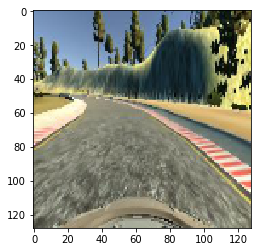

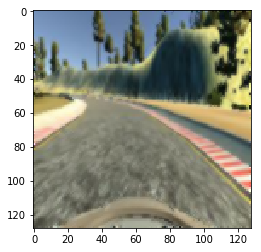

In [205]:
import matplotlib
import matplotlib.pyplot as plt
img_path = '/mnt/data/dataset2_twe_one_lap/IMG/' + os.path.basename(csv['center'][0]);
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV does not use RGB, it uses BGR
img = cv2.resize(img, (128, 128))
print(img.dtype)
print(np.mean(img))
print(np.max(img))
(img1,s) = mod_lighting(img,0);
(img2,s) = mod_shadow(img,0);
(img2,s) = mod_blur(img,0);
print(np.mean(img2))
print(np.max(img2))
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()

In [282]:
#os.listdir(os.curdir)

In [216]:
import pandas as pd
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],'B': ['B0', 'B1', 'B2', 'B3']})
df2 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],'B': ['B0', 'B1', 'B2', 'B3']})

(40180,)
steering angle has been smoothed based on window 12
(40180,)


/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:208: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  #self.data.steering = pd.rolling_mean(self.data.steering, window=window, center=True)
/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:209: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  #        self.data.steering = self.data.steering.expanding(center=True,window=10).mean()


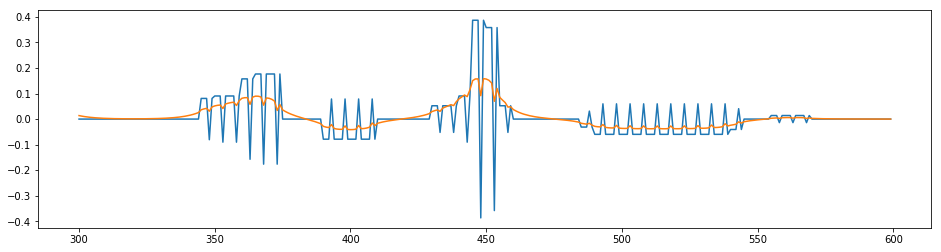

In [363]:
reload(self_driving_car)
reload(self_driving_car.data_generator)
#dir(self_driving_car.data_generator)
datagen = self_driving_car.data_generator.DataGenerator()
datagen.add_dataset("dataset1_udacity")
#datagen.add_dataset("dataset2_twe_one_lap")
#datagen.add_dataset("dataset3_ssz_one_lap")
#datagen.data.speed > 20
#x = next(datagen)
plt.figure(figsize=(16, 4))
print(datagen.data.steering.shape)
plt.plot(datagen.data.steering[300:600])
datagen.smooth_steering(12)
print(datagen.data.steering.shape)
plt.plot(datagen.data.steering[300:600])
plt.show()

In [408]:
sLength = len(datagen.data)
datagen.data['weight'] = np.ones((sLength,1),dtype=float)/sLength
np.max( np.abs(datagen.data.steering).values )
p_min = 0.3
p_max = 1.0
datagen.data['weight'] = datagen.data['steering'].map(lambda x: p_min + x*(p_max-p_min)/0.5)
datagen.data['weight'] /= datagen.data['weight'].sum()
datagen.data['weight'].sum()

0.99999999999999989

In [402]:
y = list(map(lambda x: p_min + x*(p_max-p_min)/0.5, [0,0.1,0.2,0.3,0.4,0.5]))
y

[0.3, 0.43999999999999995, 0.58, 0.72, 0.8599999999999999, 1.0]

In [485]:
valid_size = 0.1
sLength = len(datagen.data)
assert valid_size > 0 and valid_size < 1, "Invalid validation size"
sLengthValid = round(sLength * valid_size)
sLength
is_train = np.zeros([sLength],dtype=bool)
is_train[0:sLengthValid] = True
datagen.data['is_train'] = is_train;
#datagen.data.loc[0:sLengthValid].is_train = 1
#datagen.data["is_train",1:3] = True
np.sum(datagen.data['is_train'])

In [515]:
datagen.data[datagen.data['is_train'] == True]

,img,steering,throttle,brake,speed,cam,filter,weight,is_train
20547,dataset1_udacity/IMG_preprocessed/mod_blur_cen...,0.041148,0.524416,0.0,30.069599,C,mod_blur,0.000031,True
13419,dataset1_udacity/IMG_preprocessed/mod_shadow_c...,0.000011,0.985533,0.0,30.186649,C,mod_shadow,0.000026,True
2153,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,0.057977,0.985533,0.0,30.184690,C,mod_flip,0.000033,True
10853,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,0.000030,0.985533,0.0,30.186640,C,mod_flip,0.000026,True
6246,dataset1_udacity/IMG_preprocessed/mod_lighting...,0.023575,0.985533,0.0,30.186510,C,mod_lighting,0.000029,True
3209,dataset1_udacity/IMG_preprocessed/mod_shadow_c...,0.063412,0.985533,0.0,30.186640,C,mod_shadow,0.000034,True
33667,dataset1_udacity/IMG_preprocessed/mod_blur_cen...,-0.000023,0.985533,0.0,30.186470,C,mod_blur,0.000026,True
25256,dataset1_udacity/IMG_preprocessed/mod_lighting...,-0.026258,0.985533,0.0,30.186609,C,mod_lighting,0.000023,True
13498,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,0.055211,0.985533,0.0,30.185341,C,mod_flip,0.000033,True
35273,dataset1_udacity/IMG_preprocessed/mod_flip_cen...,0.056348,0.985533,0.0,30.181549,C,mod_flip,0.000033,True


In [530]:
row = datagen.data[datagen.data['is_train'] == True].iloc[0]
#row = datagen.data[0:1]
row['img']
#row['steering']

'dataset1_udacity/IMG_preprocessed/mod_blur_center_2016_12_01_13_39_34_715.jpg'

1810 samples removed due to speed < 10
steering angle has been smoothed based on window 12
higher probabilities for steering samples (sum of p = 1.000000)
shuffled data
split data into 34533 training sample and 3837 validation samples


/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:215: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  fwd = pd.stats.moments.ewma( self.data.steering.values, span=window )
/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:216: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  bwd = pd.stats.moments.ewma( self.data.steering.values[::-1], span=window )


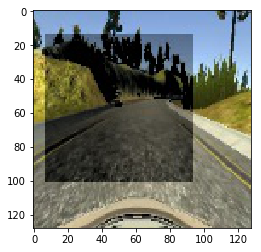

0.0866923335933


In [589]:
reload(self_driving_car)
reload(self_driving_car.data_generator)
datagen = self_driving_car.data_generator.DataGenerator()
datagen.add_dataset("dataset1_udacity")
datagen.prepare();
item = datagen.__next__()
plt.imshow(item[0])
plt.show()
print(item[1])

In [592]:
valid = datagen.get_valid_data()
#rows = datagen.data[datagen.data['is_train'] == False]
#for i,r in rows.iterrows():
#    print(r)
#    print(dir(r))
#    print(r["img"])
#    x = r
#x['img']
print(valid[0].shape)
print(valid[1].shape)

(3837, 128, 128, 3)
(3837,)


In [590]:
# gen = datagen.get_batch_generator()
datagen.reset()
for i in range(3):
    item = next(gen)
    print(item[0].shape)
    print(item[1].shape)
    print(item[1][1:10])

(256, 128, 128, 3)
(256,)
[ -5.32046847e-03   3.18867077e-02   4.94109683e-03  -4.11594969e-02
  -8.12673926e-02   4.51552372e-03   7.78842567e-02   1.11425279e-09
  -8.04000629e-02]
(256, 128, 128, 3)
(256,)
[  2.28204931e-02   1.24785081e-01  -4.60753208e-05   6.85675966e-02
   6.36671231e-03   1.12017586e-03   6.09877008e-02  -3.35774203e-03
  -8.89190135e-04]
(256, 128, 128, 3)
(256,)
[  6.25706684e-03  -6.62339005e-02  -5.39704073e-05   8.68900002e-02
  -3.74668013e-02  -2.77373744e-03  -1.11285147e-02  -5.70507155e-02
   4.52936858e-02]


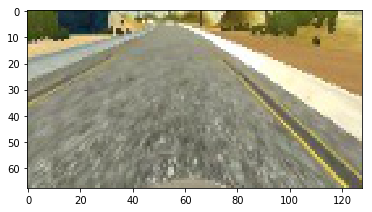

In [628]:
img = item[0][np.random.randint(0,100)]
plt.imshow(img[45:-15,:,:])
plt.show()